*created 22 Feb 2026, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 5303 "AI and Machine Learning in Ocean Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES5303_ML_ocean) page.

---
# 9. Physics Informed Neural Networks (PINNs)

> NOTE: Probably don't run this notebook all the way unless you really mean it... The second part is quite slow (~30 mins on my laptop / Colab instance per 1000 epochs per training even on a GPU).

The notebook aims to illustrate some ideas behind ***PINNs*** and how this might be implemented in PyTorch. The notebook at present is more for illustrating the ideas and some practicalities, and less on showing this is an thing that will definitely work, because at least for the ones I've tried it doesn't work all that well...

See the video on [Steve Brunton's channel](https://www.youtube.com/watch?v=-zrY7P2dVC4) for more overview. The video is particularly good because it also highlights on how PINNs can work as well as fail towards the middle of the video; some of that is mentioned here towards the end of this notebook.

> ## Key Objective(s)
> 1. Introduce the ideas behind PINNs.
> 2. Introduce some PyTorch routines for automatic differentiation for differential equations that are needed for the training of PINNs.
> 3. Demonstrating the `PyTorch` commands for usage of GPUs (cf. `Keras` more or less just does it for you).

> NOTE: I am going to use `PyTorch` here again instead of `Keras`, mostly because I couldn't be bothered figuring out how to define the modified loss functions accordingly, although I am sure you can do it.

In [1]:
# load some packages

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


---
## a) Idea behind PINNs

One thing that has been mentioned previously is that while you would like the neural networks to learn the principles behind the data directly from data, fact of the matter is that there is no reason it would (and usually it doesn't). For example, suppose we want a neural network to generate images of cats and it gets exposed to something like this:

<img src="https://i.imgur.com/YRj7twA.jpeg" width="300" alt='distortion'>

There are underlying physical principles that tell us that kind of distortion should be avoided or physically impossible. In that case maybe it's a good idea to build those underlying principles into the neural network as constraints, and/or tell the neural network to avoid solutions that violate those constraints, or some variation/combination of those. When you search for PINNs, it is the second of those the above you will normally encounter, and that's what we will be demonstrating on here.

Note that the *physics* part (the "P" in PINNs) is neither here nor there really; the main thing are constraints in some equation form (e.g. there are constraints for biological/chemical systems that can also be described in terms of equations, which would fall under the umbrella of PINNs). For the example below I am going to use the following simple ordinary differential equation (ODE):
\begin{equation*}
    \frac{\mathrm{d}f}{\mathrm{d} t} = r t(1 - t),
\end{equation*}
which you can straightforwardly integrate to give (taking $r=1$ and $f(t)=1.0$)
\begin{equation*}
    f(t) = -\frac{1}{3}t^3 + \frac{1}{2}t^2 + 1.
\end{equation*}

The equation bears some resemblance (but is not) the ***logistic equation*** (normally $f$ would be the population, and we would have exponential growth descrbied by $r f$, which is arrested eventually by the $-r f^2$ that becomes dominant when $f$ is big). The data is represented visually in below, with a few more modifications, and done in a way that `PyTorch` will understand for later use.

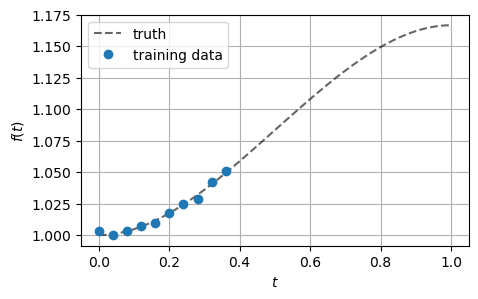

In [2]:
def analytic_solution(t):
    return (-1/3)*(t**3) + 0.5*(t**2) + 1

t = np.linspace(0, 1, 500).reshape(-1, 1)
y = analytic_solution(t).reshape(-1, 1)

t_data = t[0:200:20]
y_data = y[0:200:20]

np.random.seed(7)
y_data += 0.002 * np.random.randn(len(y_data)).reshape(-1, 1)

X_train = torch.tensor(t_data, dtype=torch.float32)  # already reshaped
Y_train = torch.tensor(y_data, dtype=torch.float32)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.plot(t, analytic_solution(t), 'k--', alpha=0.6, label="truth")
ax.plot(X_train, Y_train, 'o', label="training data")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$f(t)$")
ax.grid()
ax.legend();

So the idea here is that I have data that was sampled (given by the blue dots) subject to the presence of noise. What I would like is to train a neural network on those limited data points to sample the underlying governing equation, and then extrapolate to the region where I do not have data. Below code basically does this using a simple MLP.

> NOTE: My MLP is going to be reasonably deep, and I am going to take quite a few epochs on this.
>
> Notice I also use a hypoerbolic tanh activation function. It is suggested to use a smooth activation function for PINNs because they are differentiable (ReLU is formally not differentiable at 0); sigmoid would be another choice.

In [3]:
class MLP(nn.Module):
    def __init__(self, 
                 input_size: int = 1, 
                 output_size: int = 1, 
                 hidden_layers: int = 5, 
                 hidden_nodes: int = 10) -> None:
        super().__init__()
        
        self.inputs  = nn.Linear(input_size, hidden_nodes)
        self.model   = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers)
        self.outputs = nn.Linear(hidden_nodes, output_size) 
        
        self.activation = nn.Tanh()  # note the use of Tanh here
    
    def _apply_model(self, x: torch.Tensor) -> torch.Tensor:

        for layer in self.model:
            x = self.activation(layer(x))
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.activation(self.inputs(x))
        x = self._apply_model(x)
        x = self.outputs(x)
        return x

# wrap the training up

def training(model, optimizer, J, X_train, Y_train,
             num_epochs=100, out_epoch=None):

    if out_epoch is None:
        out_epoch = num_epochs // 10

    # define things to dump into for loss curve
    train_J = np.zeros(num_epochs)

    for epoch in range(num_epochs):

        # iteration step
        optimizer.zero_grad()  # clear gradients if it exists (from loss.backward())
        Y_pred = model(X_train)  # feed-forward
        J_train = J(Y_pred, Y_train) # compute loss
        J_train.backward()  # back propagation
        optimizer.step()  # iterate

        # diagnostics: evaluation of metrics as we go along
        train_J[epoch] = J_train.item()

        if (epoch + 1) % out_epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, "
                + f"Train Loss: {J_train.item():.6f}")

    return model, train_J

Epoch 2000/20000, Train Loss: 0.000266
Epoch 4000/20000, Train Loss: 0.000266
Epoch 6000/20000, Train Loss: 0.000265
Epoch 8000/20000, Train Loss: 0.000261
Epoch 10000/20000, Train Loss: 0.000239
Epoch 12000/20000, Train Loss: 0.000036
Epoch 14000/20000, Train Loss: 0.000026
Epoch 16000/20000, Train Loss: 0.000010
Epoch 18000/20000, Train Loss: 0.000002
Epoch 20000/20000, Train Loss: 0.000002


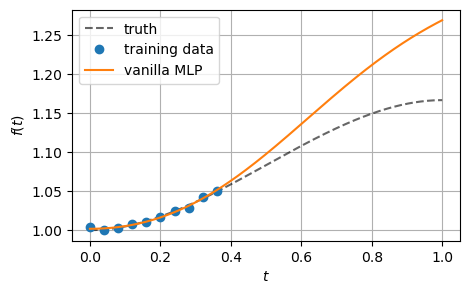

In [4]:
# Hyperparameters
epochs = 20000
lr = 1e-4

# vanilla MLP
torch.manual_seed(1234)
model = MLP(hidden_layers=7, hidden_nodes=10)
optimizer = optim.Adam(model.parameters(), lr=lr) 
J = nn.MSELoss()

model_MLP, train_J_MLP = training(model, optimizer, J, X_train, Y_train,
                                  num_epochs=epochs)

with torch.no_grad():
    y_pred_MLP  = model_MLP(torch.FloatTensor(t).view(-1, 1))

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.plot(t, analytic_solution(t), 'k--', alpha=0.6, label="truth")
ax.plot(X_train, Y_train, 'o', label="training data")
ax.plot(t, y_pred_MLP,  '-', label="vanilla MLP")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$f(t)$")
ax.grid()
ax.legend();

So note here that the MLP clearly does well within the training data range, but not so much beyond the training data range, and this should not be surprising. Question here is that if we think the data is supposed to satisfy the ODE given above, can we build that knowledge in during training somehow?

Well we could do it through the design of the cost function $J$ so that
\begin{equation*}
    J = J_{\rm data} + J_{\rm PINNs}
\end{equation*}

Just like we could penalise the model by adding a regularisation when we dealt with linear models (e.g. $L^2$ penalisation for controlling the weight sizes, $L^1$ penalisation to promote sparsity), we could also penalise the model for violating whatever principle (in the form of an ODE say) we decide to impose.

> NOTE: The above is not the only way, and might be called a ***soft constraint***, in that the constraint is only satisfied approximately (e.g. only in an integrated/averaged sense). This is to be contrasted to a ***hard constraint***, which is forcing the constraint to be satisfied exactly (up to numerical roundoff) and/or pointwise. Not going to talk about how to do the latter here, but ask me about it if you want.

> NOTE: Just like in `08_GANs` we have a competition between the generator and discriminator that can cause problems numerically, here we can have competition between the mismatch measure and the penalisation term, causing similar issues.

The above would then require us to define the ODE in a form that PyTorch can read. We would also need to do backpropagation taking into account of the imposed ODE. Thankfully PyTorch already have these things built in and its reasonably easy to use. The below code first defines the ODE as a mapping from an input tensor to another input tensor (with feature dimension of 1, since our ODE takes in $t$ and spits out $f(t)$); the parameter $r$ is defined within the subroutine itself.

In [5]:
def ode_logistic(t: torch.Tensor) -> torch.Tensor:
    R: float = 1.0
    return R * t * (1.0 - t)

I have some freedom in where I decide to force the ODE to be satisfied (the ***collocation points***), and this shows up in the form of where I want to evalute the regularisation part of $J$. Here I define the variable to be `X_PINNs`, and note that the following features in the below definition:

* I define it as a `torch.Tensor` object going from $t=[0, 1]$ in 20 steps, i.e. I am going to evaluate the model at these 20 points too see how well/badly the ODE is satisfied
* `requires_grad=True` is on, to enable taping for the backpropagation part (since the cost function value depends on the choice of `X_PINNs`)
* `dtype=torch.float32` and `.reshape(-1, 1)` is just like `FloatTensor` and the usual `.reshape` or `.view`

Below code summarises the information in a visual form.

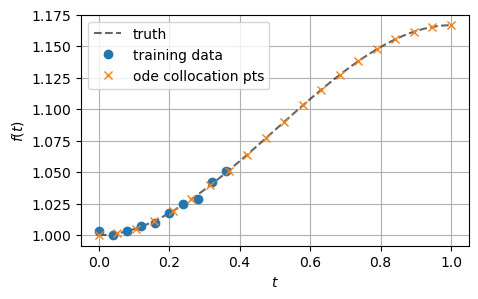

In [6]:
# define collocation point for evaluating J_PINNs
X_PINNs = torch.linspace(0, 1, 20, requires_grad=True, dtype=torch.float32).reshape(-1, 1)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.plot(t, analytic_solution(t), 'k--', alpha=0.6, label="truth")
ax.plot(X_train, Y_train, 'o', label="training data")
ax.plot(X_PINNs.detach().numpy(), analytic_solution(X_PINNs.detach().numpy()), 'x', 
        label="ode collocation pts")
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$f(t)$")
ax.grid()
ax.legend()

I am going to do the training loop slightly differently. The main new parts are that it takes in three extra arguments (`X_PINNs` the collocation points, `ode` is the ODE to be forced, and `lam_PINNs` would be weighting factor I decide to put on the regularisation), and

* `f = model(X_PINNs)` evaluates the model at the collocation points
* The `df = torch.autograd.grad(...)` step computes $\mathrm{d}\hat{f} / \mathrm{d}t$ (where $\hat{f}$ here is the neural network), with the magic step `create_graph=True` to enable the appropriate taping for backpropagation. By default `grad` computes the derivative over every dimension if they were present; in the present case there is only one dimenion, but we still need to call the `[0]` index to get the derivatve along our only dimension.
* `torch.mean((df - ode(X_PINNs))**2)` computes the $L^2$ error evaluating how good/bad the neural network satisfies the imposed `ode` at the collocation points
* Adding the new contribution to `J_train` and doing `J_train.backward()` does the backpropagation for the whole chain of operations in the usual way, made possible by the `create_graph=True` and `require_grad=True` in the various locations.

In [7]:
def training_PINN(model, optimizer, J, X_train, Y_train, 
                  X_PINNs, ode, lam_PINNs=1.0,
                  num_epochs=100, out_epoch=None):

    if out_epoch is None:
        out_epoch = num_epochs // 10

    # define things to dump into for loss curve
    train_J = np.zeros(num_epochs)

    for epoch in range(num_epochs):

        # iteration step
        optimizer.zero_grad()  # clear gradients if it exists (from loss.backward())
        Y_pred = model(X_train)  # feed-forward
        J_data = J(Y_pred, Y_train) # compute loss

        # ===========================
        # physics regularisation part: evaluate only on given locations
        f = model(X_PINNs)
        df = torch.autograd.grad(f, X_PINNs, torch.ones_like(f), create_graph=True)[0]
        J_PINNs = torch.mean((df - ode(X_PINNs))**2)
        # ===========================
        
        J_train = J_data + lam_PINNs * J_PINNs
        J_train.backward()  # back propagation
        optimizer.step()  # iterate

        # diagnostics: evaluation of metrics as we go along
        train_J[epoch] = J_train.item()

        if (epoch + 1) % out_epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, "
                + f"Train Loss: {J_train.item():.6f}")

    return model, train_J

We can then proceed to train as usual, reinitialising accordingly. I am going to use the same MLP structure as above, and the only difference here is that I call a different training loop that has the extra penalisation present.

Epoch 2000/20000, Train Loss: 0.031108
Epoch 4000/20000, Train Loss: 0.010562
Epoch 6000/20000, Train Loss: 0.001635
Epoch 8000/20000, Train Loss: 0.000502
Epoch 10000/20000, Train Loss: 0.000414
Epoch 12000/20000, Train Loss: 0.000277
Epoch 14000/20000, Train Loss: 0.000073
Epoch 16000/20000, Train Loss: 0.000007
Epoch 18000/20000, Train Loss: 0.000005
Epoch 20000/20000, Train Loss: 0.000005


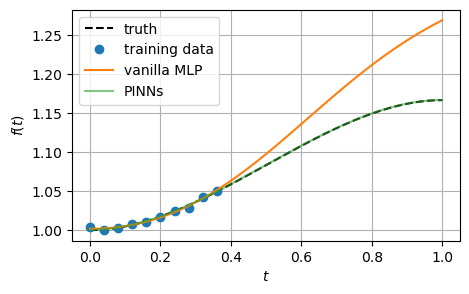

In [8]:
# Hyperparameters
epochs = 20000
lr = 1e-4

# re-initialise for the PINNs one
torch.manual_seed(1234)
model = MLP(hidden_layers=7, hidden_nodes=10)
optimizer = optim.Adam(model.parameters(), lr=lr) 
J = nn.MSELoss()

model_PINN, train_J_PINN = training_PINN(model, optimizer, J, X_train, Y_train,
                                         X_PINNs, ode_logistic,
                                         num_epochs=epochs)

with torch.no_grad():
    y_pred_PINN = model_PINN(torch.FloatTensor(t).view(-1, 1))

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.plot(t, analytic_solution(t), 'k--', label="truth")
ax.plot(X_train, Y_train, 'o', label="training data")
ax.plot(t, y_pred_MLP,  '-', label="vanilla MLP")
ax.plot(t, y_pred_PINN, '-', label="PINNs", alpha=0.6)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$f(t)$")
ax.grid()
ax.legend();

Looks ok! You could think of imposing the penalisation as forcing the neural network to reproduce solutions of a certain "shape" if you like.

> <span style="color:red">Q.</span> There are a few things you should experiment, because the fact the above *works* required quite a bit of experimenting that I hid from you. Consider changing:
> * the noise level of the data
> * the number of data points passed for the neural net training
> * the number of collocation points
> * the distribution of collocation points (e.g. not having it everywhere, but bias it to the places where you don't have data)
> * network architecture
> * training rate
> * solver parameter values
> * penalisation weights
> and others.
>
> <span style="color:red">Q.</span> Try this for other ODEs. There are a few that really did not work for me (e.g. $\mathrm{d}f / \mathrm{d}t = -r(f_{\rm background} - f)$, which if you view $f$ as some temperature would end up being an exponential decay to some background temperature $f_{\rm background}$ with some rate $r$).
>
> One problem with the exponential decay problem may be the data scaling of the cases I chose: I tried a "real" example, with $f(0) = 100^{\circ}\ \mathrm{C}$ and decaying to $f_{\rm background} = 25^{\circ}\ \mathrm{C}$ with a rate of $r = 0.005^{\circ}\ \mathrm{C}\ \mathrm{s}^{-1}$, and it went from 0 to 1000 seconds. Another could be the number of collocation points I provided: having too many made it too slow, but it also meant it wasn't constrained enough.

---
## b) A more involved example involving a PDE

> NOTE!!! The training loops below are not fast (~10-15 mins for me). Could speed it up by reducing the number of epochs probably.

We can consider a more complicated problem involving a Partial Differential Equation (PDE), to demonstrate some additional things with `autograd.grad` and some GPU-based computation if want to get some speed.

> NOTE: On Colab you can make it use GPUs with a free session (if they are available) at the top right with "Change runtime type". See below image.
>
> <img src="https://i.imgur.com/wBfMT8O.png" width="800" alt='colab GPU'>
>
> I am not convinced I got speed ups with using GPU compared to running it on my laptop for the below problem, so it could be that I didn't set it up very well...

The heat equation or diffusion equation is given by
\begin{equation*}
    \frac{\partial u}{\partial t} = \kappa\frac{\partial^2 u}{\partial x^2},
\end{equation*}
for $u(x, t)$, with initial conditions $u(x, 0)$ and boundary condition $u(\pm L, t)$ specified accordingly; you can interpret $u$ as the temperature if you like, and models how the temperature diffuses over time. The below example chooses $\kappa=2$, $L=5$, with boundary conditions to be $u=0$ and initial condition to be $u = \sin(\pi x)$; convince yourself the (unique) solution satisfying both initial and boundary conditions is
\begin{equation*}
    u(x, t) = \sin(\pi x) \mathrm{e}^{-2\pi^2 t}.
\end{equation*}
The solution is visualised below.

> <span style="color:red">Q.</span> Show above is in fact a solution of the heat equation. You can just shove it into the PDE to check the left and right sides agree (and that the boundary conditions are satisfied for all time).
>
> You could also derive the general solution and then substitute the parameter numbers in accordingly. Usual approach would be what is called separation of variables. A Fourier transform in $x$ would be another possibility.

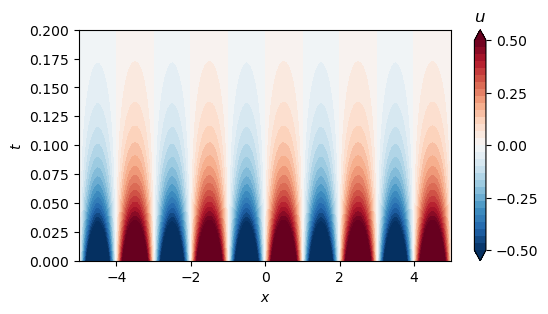

In [9]:
# plot the analytical solution to the heat/diffusion equation
def u(x, t):
    return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)

pts = 200
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)

X, T = np.meshgrid(xs, ts)
U = u(X, T)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
cs = ax.contourf(xs, ts, U, cmap="RdBu_r",
                 levels=np.linspace(-0.5, 0.5, 31), extend="both")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$t$")
cax = plt.colorbar(cs)
cax.ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
cax.ax.set_title(r"$u$");

I saturated the graph a bit to show a bit more colour towards the top of the graph for later calculations. Here time goes upwards, so what is happening is that as we move forward in time, the oscillatory shape of the solution gets increasingly damped and the gradients are being reduced (described by the $\mathrm{e}^{-2\pi^2 t}$ term); it is being "diffused". The task here is given the solution data to train up a neural network to take in a pair of values $x$ and $t$ and return a value $u_{\rm nn}(x, t)$.

Below I define a simple MLP structure with a tanh activation function again.

In [10]:
class Net(torch.nn.Module):

    def __init__(self, indim=1, outdim=1):
        super().__init__()
        self.activation = nn.Tanh()  # note the use of Tanh here
        self.lin1 = nn.Linear(indim, 100)
        self.lin2 = nn.Linear(100, outdim)

    def forward(self, x):
        x = self.activation(self.lin1(x))
        x = self.lin2(x)
        return x.squeeze()    

I am going to use a `Dataset` and `DataLoader` here because I will want to do some batching.

In [11]:
# define custom dataset to do allow for batching
class MyDataset(Dataset):

    def __init__(self, in_tensor, out_tensor):
        self.inp = in_tensor
        self.out = out_tensor

    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx):
        return self.inp[idx], self.out[idx]    

train_in = torch.tensor([[x, t] for x, t in zip(X.flatten(), T.flatten())],
                        dtype=torch.float32, requires_grad=True).to(device)
train_out = torch.tensor(u(X.flatten(), T.flatten()), dtype=torch.float32).to(device)

train_dataset = MyDataset(train_in, train_out)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

I am going to do one more thing first, by defining the physics loss and also the boundary constraints. 

For the physics loss, here my function $u(x,t)$ is stored as a two dimensional array, so when I do grad on it it will be the derivatives over the respective direction. Because of how it is set up, $t$ is in the second dimension (index `1`), while $x$ is at index `0`. Here I need two derivatives in $x$, so I hit one of the output with another `grad`. Then I compute the loss as a mean squared error between `d2udx2` and `0.5*dudt`, because my equation is $\partial u / \partial t = \kappa \partial^2 u / \partial x^2$, but I chose $\kappa=2$, so we have $0.5 \partial u / \partial t = \partial^2 u / \partial x^2$ in code form.

For the boundary condition, I am defining where the boundary points are and evaluating my analytical solution at those points (it's basically all zeros in the end). I also make the inputs to be taped, and pass inputs/outputs to the GPU with `.to(device)`.

In [12]:
# constraints to force PDE and boundary condition

def phys_loss(inp, out):
    dudt = torch.autograd.grad(out, inp, grad_outputs=torch.ones_like(out),
                               create_graph=True,
                               allow_unused=True)[0][:,1]
    dudx = torch.autograd.grad(out, inp, grad_outputs=torch.ones_like(out),
                               create_graph=True,
                               allow_unused=True)[0][:,0]
    d2udx2 = torch.autograd.grad(dudx, inp, grad_outputs=torch.ones_like(dudx),
                                 create_graph=True,
                                 allow_unused=True)[0][:,0]
    return torch.nn.MSELoss()(d2udx2, 0.5*dudt)

bdry_pts = 200
xs_bdry = np.linspace(-5, 5, bdry_pts)
ts_bdry = np.asarray([0 for x in xs_bdry])
us_bdry = u(xs_bdry, ts_bdry)

train_in_bd = torch.tensor([[x, t] for x, t in zip(xs_bdry, ts_bdry)],
                           dtype=torch.float32, requires_grad=True).to(device)
train_out_bd = torch.tensor(us_bdry, dtype=torch.float32).to(device)

Now we are good to train. Below code does the looping over epochs for the case where I ***don't*** put in the constraints/penalisations. 

How I did this was actually to use the one for PINNs but comment a few lines out, because I want to recycle some code to evaluate how well the loss is going down (or not) in terms of the given data (`J_base`), how it satisfies the PDE (`J_phys`) and at the boundaries (`J_bdry`). By commenting the relevant lines I:

* don't make `batch_in` a taped variable (because I don't need taping if I am not doing PINNs for this vanilla case)
* don't add the penalisations to the loss function (because I am not enforcing those constraints)

However when I am in evaluation rather than training mode, I still evaluate how well the PDE and boundary conditions are satisfied. There is of course no reason the loss of those will be low, and you should find it is in fact not low.

In [13]:
# MLP training loop with no ODE constraint, but evaluating ODE and boundary loss anyway

torch.manual_seed(1234)
model_MLP = Net(indim=2, outdim=1).to(device)

num_epochs = 500
optimizer = torch.optim.Adam(model_MLP.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

for epoch in range(num_epochs):
    for batch_in, batch_out in train_dataloader:
        # batch_in = torch.autograd.Variable(batch_in, requires_grad=True).to(device)
        batch_in = batch_in.to(device)
        bactch_out = batch_out.to(device)
        model_MLP.train()
        optimizer.zero_grad()
        J_train = mse_loss(model_MLP(batch_in), batch_out)
        # J_train += phys_loss(batch_in, model_PINNs(batch_in))
        # J_train += mse_loss(model_PINNs(train_in_bd), train_out_bd)
        J_train.backward()
        optimizer.step()
    model_MLP.eval()
    J_base = mse_loss(model_MLP(train_in), train_out)
    J_phys = phys_loss(train_in, model_MLP(train_in))
    J_bdry = mse_loss(model_MLP(train_in_bd), train_out_bd)
    # J_loss = base + phys + bdry

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1}/{num_epochs} | " +
              f"Loss: {J_base:.6f} (+ {J_phys:6f} + {J_bdry:.6f})")

Epoch: 10/500 | Loss: 0.059996 (+ 0.049751 + 0.469978)
Epoch: 20/500 | Loss: 0.057818 (+ 0.672499 + 0.444584)
Epoch: 30/500 | Loss: 0.054533 (+ 0.911189 + 0.433822)
Epoch: 40/500 | Loss: 0.048721 (+ 0.818746 + 0.403419)
Epoch: 50/500 | Loss: 0.044721 (+ 1.292099 + 0.374272)
Epoch: 60/500 | Loss: 0.041695 (+ 1.844338 + 0.351329)
Epoch: 70/500 | Loss: 0.039850 (+ 2.273720 + 0.335084)
Epoch: 80/500 | Loss: 0.038077 (+ 2.473819 + 0.320053)
Epoch: 90/500 | Loss: 0.036538 (+ 2.543878 + 0.309440)
Epoch: 100/500 | Loss: 0.035286 (+ 2.564341 + 0.297533)
Epoch: 110/500 | Loss: 0.036430 (+ 2.586368 + 0.291444)
Epoch: 120/500 | Loss: 0.034012 (+ 2.588592 + 0.280703)
Epoch: 130/500 | Loss: 0.030947 (+ 2.646462 + 0.267896)
Epoch: 140/500 | Loss: 0.029854 (+ 2.684031 + 0.255944)
Epoch: 150/500 | Loss: 0.028231 (+ 2.656416 + 0.246645)
Epoch: 160/500 | Loss: 0.026732 (+ 2.608583 + 0.235877)
Epoch: 170/500 | Loss: 0.025742 (+ 2.464522 + 0.225218)
Epoch: 180/500 | Loss: 0.024559 (+ 2.311229 + 0.216561)
E

Going to visualise the predictions from the vanilla model, using the same plotting settings as the analytical solution above to highlight various properties. Below is some magic incantations to get things working.

> NOTE: The model is expecting `Tensor` inputs so we redefine those using the PyTorch functions below. The model is on the GPU so you would need to send the tensor object to the GPU, which is done with `.to(device)` in `u_model`.
>
>  The thing that is less obvious is when you want to plot it. The sequence of operations below are (as far as I can tell) `.detach()` to take it off the computation graph for evaluation, `.cpu()` to put data back onto the cpu, `.numpy()` to make it a numpy array, and `.tolist()` to make it into a list of points (because it was easier to dump it into a list rather than in an array). If you are already on a cpu then only the `.numpy().tolist()` actually do stuff.

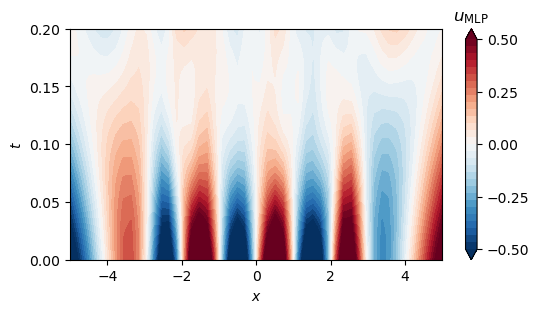

In [14]:
def u_model(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]),
                       dtype=torch.float32).to(device)
    return model_MLP(pts)

pts = 50
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts, indexing="ij")
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model(x, t).detach().cpu().numpy().tolist())

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
cs = ax.contourf(xs, ts, img, 
                 cmap="RdBu_r", levels=np.linspace(-0.5, 0.5, 31), extend="both")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$t$")
cax = plt.colorbar(cs)
cax.ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
cax.ax.set_title(r"$u_{\rm MLP}$");

What you should notice is that something a bit funny is happening even near $t=0$ at the bottom of the figure, where we clearly do not get a sine-like signal we are supposed to get. There are some patterns we get towards the top of the figure that is not like diffusion either. The hope/aim of PINNs is that enforcing the PDE fixes that. The below code does all of the above again but switching on the taping and adding the penalisations to the loss terms. We go straight to plotting the prediction also.

In [15]:
# PINN training loop with ODE constraint

torch.manual_seed(1234)
model_PINNs = Net(indim=2, outdim=1).to(device)

num_epochs = 500
optimizer = torch.optim.Adam(model_PINNs.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

for epoch in range(num_epochs):
    for batch_in, batch_out in train_dataloader:
        batch_in = torch.autograd.Variable(batch_in, requires_grad=True).to(device)
        bactch_out = batch_out.to(device)
        model_PINNs.train()
        optimizer.zero_grad()
        J_train = mse_loss(model_PINNs(batch_in), batch_out)
        J_train += phys_loss(batch_in, model_PINNs(batch_in))
        J_train += mse_loss(model_PINNs(train_in_bd), train_out_bd)
        J_train.backward()
        optimizer.step()
    model_PINNs.eval()
    J_base = mse_loss(model_PINNs(train_in), train_out)
    J_phys = phys_loss(train_in, model_PINNs(train_in))
    J_bdry = mse_loss(model_PINNs(train_in_bd), train_out_bd)
    J_loss = J_base + J_phys + J_bdry

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch+1} | " +
              f"Loss: {J_loss:.6f} = {J_base:.6f} + {J_phys:6f} + {J_bdry:.6f}")

Epoch: 10 | Loss: 0.525776 = 0.063293 + 0.004808 + 0.457675
Epoch: 20 | Loss: 0.520830 = 0.062235 + 0.008346 + 0.450248
Epoch: 30 | Loss: 0.517503 = 0.063785 + 0.008680 + 0.445038
Epoch: 40 | Loss: 0.510037 = 0.061753 + 0.009004 + 0.439280
Epoch: 50 | Loss: 0.495051 = 0.059506 + 0.015418 + 0.420126
Epoch: 60 | Loss: 0.482096 = 0.057179 + 0.024880 + 0.400037
Epoch: 70 | Loss: 0.473207 = 0.056390 + 0.030437 + 0.386380
Epoch: 80 | Loss: 0.465894 = 0.057092 + 0.035683 + 0.373120
Epoch: 90 | Loss: 0.458553 = 0.051771 + 0.038580 + 0.368201
Epoch: 100 | Loss: 0.449329 = 0.052828 + 0.041503 + 0.354997
Epoch: 110 | Loss: 0.440957 = 0.051384 + 0.042125 + 0.347448
Epoch: 120 | Loss: 0.431068 = 0.048832 + 0.043942 + 0.338294
Epoch: 130 | Loss: 0.420635 = 0.048622 + 0.047188 + 0.324825
Epoch: 140 | Loss: 0.411465 = 0.049362 + 0.048536 + 0.313567
Epoch: 150 | Loss: 0.401150 = 0.046689 + 0.052356 + 0.302105
Epoch: 160 | Loss: 0.390277 = 0.045739 + 0.051752 + 0.292786
Epoch: 170 | Loss: 0.381861 = 0.0

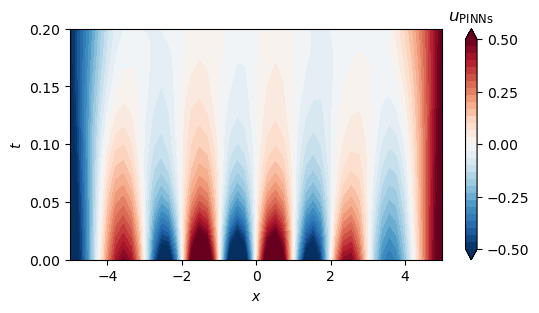

In [16]:
def u_model_PINNs(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), 
                       dtype=torch.float32).to(device)
    return model_PINNs(pts)

pts = 50
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts, indexing="ij")
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model_PINNs(x, t).detach().cpu().numpy().tolist())

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
cs = ax.contourf(xs, ts, img, cmap="RdBu_r",
                 levels=np.linspace(-0.5, 0.5, 31), extend="both")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$t$")
cax = plt.colorbar(cs)
cax.ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
cax.ax.set_title(r"$u_{\rm PINNs}$");

So we see from tracking the loss terms that the PDE and boundary condition losses are going down, and running it for more epochs will probably have it go down more. The interior portion could be argued to have improved, although we have problems at the boundaries; this could be improved with some hyper-parameter tuning or letting the model run more epochs.

> <span style="color:red">Q.</span> There are a few things you should experiment. Consider:
> * adding noise to the data (there is currently no noise)
> * adjust the number of data points passed for the neural net training
> * change the number of batches (previously we've found smaller batches tend to work "better")
> * network architecture
> * training rate
> * solver parameter values
> * penalisation weights (by not having the variables I basically set it all to be 1)
> and others.

---
## c) Some comments

The thing to note is that imposing constraints is probably helpful, but I think you would be justified in also asking the question "was it worth it", and "could effort have been better spent elsewhere"? 

Arguably the above cases are a bit contrived, because you could probably derive the analytical solutions by hand faster than the neural networks can train (unless I screwed up the coding and made the code unnecessarily slow). That point probably doesn't apply for complicated things like the [Navier-Stokes](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations) equation or other things with enough complexity.

One could also argue maybe we can get it to work with enough tuning and/or training. You would also be correct if asking "if we dedicate so much time experimenting, might it be better to dedicate that effort to solve the classic problem better"? That I don't have a good rebuttal to (I came into this a bit biased already; see this [blog post](https://www.understandingai.org/p/i-got-fooled-by-ai-for-science-hypeheres) for example).

One thing I haven't done above is to use PINNs for ***parameter estimation*** and ***inverse problems***, which probably has some mileage there. There is however of course classic ideas that probably work ok also.

Don't get me wrong, I think the idea behind PINNs is really interesting. There have been interesting works to assess why PINNs don't work as well as they might, and ultimately the idea is that constrained optimisation is a harder problem, because there is a competition between fitting to the data and fitting to enforce constraints, which makes the resulting numerical problem ***stiff*** and not entirely well-behaved. Neural networks probably work better for *un*constrained optimisation. Some proposed methods in fixing this involves ***curriculum training***, where you train a model with a small weight on the penalisation, and gradually increase it (cf. ***continuation*** approaches in classical optimisation). Alternative approaches include:

* building the constraints into the neural network itself (e.g. adding layers that enforce constraints)
* using the dynamical model, but substituting some parts with neural network, so constraints are enforced to some degree by the dynamical model itself (e.g. 4DVAR and adjoint optimisation approaches)
* using classical methods (e.g. 4DVAR), but using neural networks to speed up the convergence of those classic methods (e.g. neural networks to help with prediction of iterations during the 4DVAR updates)

and so forth. The idea of PINNs may be that the idea is interesting and has extensions, but the jury is probably still out on how "good" they are (again, "good" is question and metric dependent).

----------------
# More involved exercises with this notebook

## 1) PINNs with other architectures and other problems

See how you might use CNNs, RNNs etc. instead of MLPs for doing PINNs. Probably stick with easy ODEs and/or PDEs first.

I would suggest trying to do a CNN one with the heat equation above first, then I would try and do a ConvLSTM maybe. You could also try the other equations that were introduced in `07_RNNs` (Lotka-Volterra, Lorenz, KdV, Kuramoto-Sivashinsky), which gives you practice on implementing the equations in `PyTorch`; I would suggest starting with the ODEs first (Lotka-Volterra and Lorenz). Look up others too if you want.

## 2) Curriculum learning

***Curriculum learning*** would be when you take a trained model at one hyper-parameter as a starting point for retraining at a different hyper-parameter, idea being that a good initial condition helps with model convergence. This is like the ***continuation*** approach in numerical and optimisation problems, where you solve a "wrong" but easier problem first, and use that solution to help you iterate towards solving the problem you actually want to solve.

See how you would wrap that up by first learning a model with a weak penalisation first, then gradually increase that penalisation.

## 3) Inverse problems

In the simpler ODE example there was a parameter $r$ I set to be $1$, and the resulting ODE is forced as a constraint. Consider the case where you have the same data and know that data comes from the same ODE, but you don't actually know the value of $r$ but want to infer it from data. See how you might massage the code to do the training and make the model return that unknown parameter $r$ back to you (you know here the answer should be 1 of course).

This would be an ***parameter inference*** problem, or an ***inverse problem***, where your control variable is $r$. You basically need to tell PyTorch that $r$ is a control variable that needs to be taped accordingly etc. See if this [online entry](https://moduledebug.com/2024/12/27/physics-informed-neural-networks-pinns-using-pytorch/) might help.

## 4) Other packages

There are other packages that do PINNs are related things (e.g. PinnDE, [paper](https://www.arxiv.org/pdf/2408.10011), [GitHub](https://github.com/JB55Matthews/PinnDE)), which may work better (because the libraries are designed with solving differential equations in mind).

## 5) Implementation in `Keras`

Try getting PINNs working in `Keras`. 

The thing that will be a bit tricky is to get the taping right. Have a look at this (probably out-of-date) [example](https://github.com/tyagi-ankit/keras_PINN) how this might be done. There are other resources on the internet, although most of these seem to be using the `TensorFlow` package, so making it work in `PyTorch` will be doable but will take a bit of work probably.